In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prometheus_pandas import query
from IPython.display import Markdown, display

pd.__version__

'2.0.0'

In [43]:
p = query.Prometheus('http://192.168.178.64:9090')
step = "1s"

In [44]:
# We're scraping much more data than we actually need.
# This is especially true for devices.
# In this section we define which devices we actually want to analyze.

NET_DEVICES=["docker0","enp7s0","lo"]
DISK_DEVICES=["sda"]

# Utils

In [4]:
def printmd(string):
    display(Markdown(string))
    
def remove_meta_columns(df):
    cols = [col for col in df.columns if col not in ['measurement','seconds']]
    return df[cols]

    
def describe_measurement_dataframe(df):
    printmd("### Total ")
    display(remove_meta_columns(df).describe())
    
    printmd("### Per Measurement")
    display(df[df.columns.difference(['seconds'])].groupby('measurement').describe().unstack(1))

def prepare_query_range_as_dataframe(measurement_no, query, start, end, step=step):
    print(f"[Measurement {measurement_no}] Querying '{query}' from {start} to {end} with step {step} ...")
    metrics = p.query_range(query, start, end, step)
    metrics = metrics.assign(seconds=range(len(metrics)))
    metrics = metrics.assign(measurement=measurement_no)
    
    summarize_outliers(metrics.reset_index())
    
    return metrics


def prepare_query_metrics_as_dataframe(measurement_no, query, end):
    print(f"[Measurement {measurement_no}] Querying '{query}' at {end} ...")
    metrics = p.query(query, end).to_frame()
    metrics.columns = ['value']
    metrics = metrics.assign(measurement=measurement_no)

    summarize_outliers(metrics.reset_index())
    
    return metrics


def prepare_dataframe(query_fn, df):
    result = [prepare_query_range_as_dataframe(idx, query_fn(start, duration, end), start, end) for idx, (start, duration, end) in enumerate(zip(df['Start'], df['Duration'], df['End']), 1)]
    result = pd.concat(result)
    return result


def prepare_series(query_fn, df):
    result = [prepare_query_metrics_as_dataframe(idx, query_fn(start, duration, end), end) for idx, (start, duration, end) in enumerate(zip(df['Start'], df['Duration'], df['End']), 1)]
    result = pd.concat(result)
    return result


def mark_outliers(df, fence=2.22):
    # Select only numeric columns
    cols = df.select_dtypes('number').columns
    df_sub = df.loc[:, cols]
    
    # Calculate IQR
    iqr = df_sub.quantile(0.75, numeric_only=False) - df_sub.quantile(0.25, numeric_only=False)
    lim = np.abs((df_sub - df_sub.median()) / iqr) < fence
    
    # Replace Outliers with NaN
    df.loc[:, cols] = df_sub.where(lim, np.nan)
    
    # Replace all NaN values
    return df


def summarize_outliers(df, fence=2.22):
    marked_outliers = mark_outliers(df, fence)
    diff = df.compare(marked_outliers)
    
    # No Outliers, no problem
    if diff.size == 0:
        return
    
    diff.name = 'Outliers'
    print('Outliers detected, please check manually')
    print(diff)
    

def drop_outliers(df, fence=2.22):
    cols = df.select_dtypes('number').columns
    return mark_outliners(df, fence).dropna(how='any', subset=cols)

# Data Preparation

In [57]:
DEFAULT_RANGE="10s"
# This is going to be the label filter we're going to use
net_filter_label = f"{{device=~\"{'|'.join(NET_DEVICES)}\"}}"
# This is going to be the label filter we're going to use
disk_filter_label = f"{{device=~\"{'|'.join(DISK_DEVICES)}\"}}"
interrupts_filter = f"{{devices=\"\"}}"

def prepare_power_metrics(measurement_dataframe):
    power_metrics = prepare_dataframe(lambda start,duration,end: '{__name__=~"epc1202PowerActive|epc1202Current|epc1202Voltage"}', measurement_dataframe)
    power_metrics.columns = ['Current', 'Watts', 'Voltage', 'seconds', 'measurement']
    return power_metrics

def prepare_cpu_seconds_in_mode(measurement_dataframe):
    return prepare_series(lambda start,duration,end: f"avg by (mode) (increase(node_cpu_seconds_total[{duration}]))", measurement_dataframe)

def prepare_cpu_utilization(measurement_dataframe):
    rng = DEFAULT_RANGE
    return prepare_dataframe(lambda start, duration, end: f"avg by (mode) (rate(node_cpu_seconds_total[{DEFAULT_RANGE}]) * 100)", measurement_dataframe)

def prepare_memory_utilization(measurement_dataframe):
    rng = DEFAULT_RANGE
    query = f"""
      100 * (1 - ((avg_over_time(node_memory_MemFree_bytes[{rng}]) + avg_over_time(node_memory_Cached_bytes[{rng}]) + avg_over_time(node_memory_Buffers_bytes[{rng}])) / avg_over_time(node_memory_MemTotal_bytes[{rng}])))
    """
    return prepare_dataframe(lambda start, duration, end: query, measurement_dataframe)

def prepare_network_received_bytes(measurement_dataframe):
    return prepare_series(lambda start, duration, end: f"sum by(device) (increase(node_network_receive_bytes_total{net_filter_label}[{duration}])) / 1000", measurement_dataframe)

def prepare_network_transmitted_bytes(measurement_dataframe):
    return prepare_series(lambda start, duration, end: f"sum by(device) (increase(node_network_transmit_bytes_total{net_filter_label}[{duration}])) / 1000", measurement_dataframe)

def prepare_network_average_receive_rate(measurement_dataframe):
    return prepare_dataframe(lambda start, duration, end: f"avg by (device) (rate(node_network_receive_bytes_total{net_filter_label}[{DEFAULT_RANGE}]))", measurement_dataframe)

def prepare_network_average_transmit_rate(measurement_dataframe):
    return prepare_dataframe(lambda start, duration, end: f"avg by (device) (rate(node_network_transmit_bytes_total{net_filter_label}[{DEFAULT_RANGE}]))", measurement_dataframe)

def prepare_total_disk_io_seconds(measurement_dataframe):
    return prepare_series(lambda start, duration, end: f"increase(node_disk_io_time_seconds_total{disk_filter_label}[{DEFAULT_RANGE}])", measurement_dataframe)

def prepare_disk_io_rate(measurement_dataframe):
    return prepare_dataframe(lambda start, duration, end: f"avg by (device) (rate(node_disk_io_time_seconds_total{disk_filter_label}[{DEFAULT_RANGE}]))", measurement_dataframe)

def prepare_interrupts(measurement_dataframe):
    return prepare_series(lambda start, duration, end: f"sum by (devices, type) (idelta(node_interrupts_total{interrupts_filter}[{duration}]) > 0)", measurement_dataframe)

# Baseline Analysis

Here we take a look at the Baseline of our DUT


In [46]:
bm = pd.read_csv('baseline.csv')
bm

,Start,End,Duration,Energy
0,1681634834,1681635134,5m,4


## Power Stats

In [51]:
result = prepare_power_metrics(bm)

[Measurement 1] Querying '{__name__=~"epc1202PowerActive|epc1202Current|epc1202Voltage"}' from 1681634834 to 1681635134 with step 1s ...


In [52]:
describe_measurement_dataframe(result)

### Total 

,Current,Watts,Voltage
count,301.000000,301.000000,301.000000
mean,262.259136,47.438538,237.239203
std,0.786951,0.497034,0.427307
min,261.000000,47.000000,237.000000
25%,262.000000,47.000000,237.000000
50%,262.000000,47.000000,237.000000
75%,263.000000,48.000000,237.000000
max,265.000000,48.000000,238.000000


### Per Measurement

                measurement
Current  count  1              301.000000
         mean   1              262.259136
         std    1                0.786951
         min    1              261.000000
         25%    1              262.000000
         50%    1              262.000000
         75%    1              263.000000
         max    1              265.000000
Voltage  count  1              301.000000
         mean   1              237.239203
         std    1                0.427307
         min    1              237.000000
         25%    1              237.000000
         50%    1              237.000000
         75%    1              237.000000
         max    1              238.000000
Watts    count  1              301.000000
         mean   1               47.438538
         std    1                0.497034
         min    1               47.000000
         25%    1               47.000000
         50%    1               47.000000
         75%    1               48.000000
      

### Current Measurment Plots

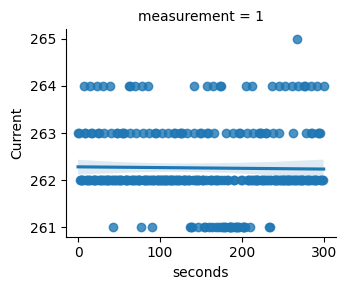

In [53]:
printmd("### Current Measurment Plots")
sns.lmplot(
      data=result, x="seconds", y="Current", col="measurement", col_wrap=5, height=3
)

### Voltage Measurment Plots

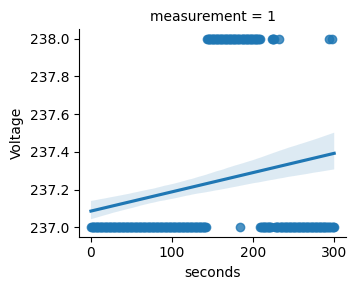

In [54]:
printmd("### Voltage Measurment Plots")
sns.lmplot(
    data=result, x="seconds", y="Voltage", col="measurement", col_wrap=5, height=3
)

### Watts Measurment Plots

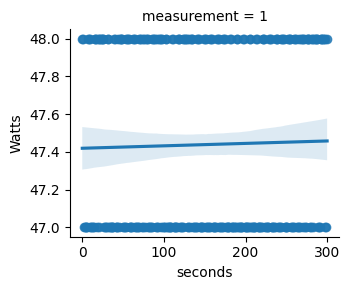

In [55]:
printmd("### Watts Measurment Plots")
sns.lmplot(
    data=result, x="seconds", y="Watts", col="measurement", col_wrap=5, height=3
)

### Total Mean Plots

(0.0, 50.0)

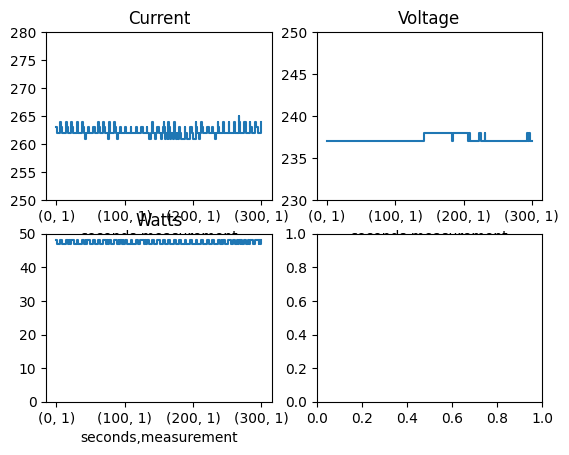

In [56]:
printmd("### Total Mean Plots")

grouped_total_mean = result.groupby(by=['seconds', 'measurement']).mean()

fig, axes = plt.subplots(nrows=2, ncols=2)
grouped_total_mean['Current'].plot(drawstyle='steps', ax=axes[0,0]);
axes[0,0].set_title('Current')
axes[0,0].set_ylim(bottom=250, top=280)
grouped_total_mean['Voltage'].plot(drawstyle='steps', ax=axes[0,1]);
axes[0,1].set_title('Voltage')
axes[0,1].set_ylim(bottom=230, top=250)
grouped_total_mean['Watts'].plot(drawstyle='steps', ax=axes[1,0]);
axes[1,0].set_title('Watts')
axes[1,0].set_ylim(bottom=0, top=50)

## CPU

### CPU Time

[Measurement 1] Querying 'avg by (mode) (increase(node_cpu_seconds_total[5m]))' at 1681635134 ...


### Total 

,value
count,8.000000
mean,37.464413
std,105.365199
min,0.000000
25%,0.000000
50%,0.020067
75%,0.464047
max,298.227843


### Per Measurement

              measurement
value  count  1                8.000000
       mean   1               37.464413
       std    1              105.365199
       min    1                0.000000
       25%    1                0.000000
       50%    1                0.020067
       75%    1                0.464047
       max    1              298.227843
dtype: float64

,value
"{mode=""idle""}",298.227843
"{mode=""iowait""}",0.003135
"{mode=""irq""}",0.000000
"{mode=""nice""}",0.000000
"{mode=""softirq""}",0.036998
"{mode=""steal""}",0.000000
"{mode=""system""}",0.204431
"{mode=""user""}",1.242893


<Axes: ylabel='CPU seconds'>

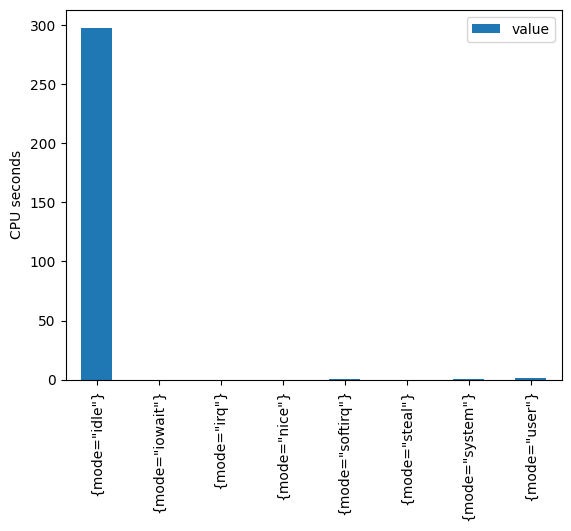

In [58]:
result = prepare_cpu_seconds_in_mode(bm)
describe_measurement_dataframe(result)

total_mean_result = remove_meta_columns(result).groupby(level=0).mean()

display(total_mean_result)
total_mean_result.plot.bar(ylabel='CPU seconds')

### CPU Utilization

In [ ]:
result = prepare_cpu_utilization(bm)
describe_measurement_dataframe(result)

grouped_mean = result.groupby(by=['seconds']).mean()
grouped_mean.drop(['measurement'], inplace=True, axis=1)
grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylim=(-5,105),ylabel='%')

## Memory

In [106]:
result = prepare_memory_utilization(bm)
describe_measurement_dataframe(result)

grouped_mean = result.groupby(by=['seconds']).mean()
grouped_mean.drop(['measurement'], inplace=True, axis=1)
grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylim=(-5,105),ylabel='%')

NameError: name 'prepare_memory_utilization' is not defined

## Network

In [ ]:
# This is going to be the label filter we're going to use
net_filter_label = f"{{device=~\"{'|'.join(NET_DEVICES)}\"}}"

### Received KBytes

In [ ]:
result = prepare_network_received_bytes(bm)
describe_measurement_dataframe(result)

grouped_mean = result.groupby(level=0).mean()
grouped_mean.drop(['measurement'], inplace=True, axis=1)
grouped_mean.plot.bar(ylabel='Received KBytes')

In [ ]:
result = prepare_network_average_receive_rate(bm)
describe_measurement_dataframe(result)

grouped_mean = result.groupby(by=['seconds']).mean()
grouped_mean.drop(['measurement'], inplace=True, axis=1)
grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylabel='Bytes')

### Sent KByte

In [ ]:
result = prepare_network_transmitted_bytes(bm)
describe_measurement_dataframe(result)

grouped_mean = result.groupby(level=0).mean()
grouped_mean.drop(['measurement'], inplace=True, axis=1)
grouped_mean.plot.bar(ylabel='Sent KBytes')

In [ ]:
result = prepare_network_average_transmit_rate(bm)
describe_measurement_dataframe(result)

grouped_mean = result.groupby(by=['seconds']).mean()
grouped_mean.drop(['measurement'], inplace=True, axis=1)
grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylabel='Bytes')

# Disk

In [ ]:
# This is going to be the label filter we're going to use
disk_filter_label = f"{{device=~\"{'|'.join(DISK_DEVICES)}\"}}"

In [ ]:
result = prepare_total_disk_io_seconds(bm)

grouped_result = result.groupby(level=0).mean()
display(grouped_result)

In [ ]:
result = prepare_disk_io_rate(bm)
describe_measurement_dataframe(result)

grouped_mean = result.groupby(by=['seconds']).mean()
grouped_mean.drop(['measurement'], inplace=True, axis=1)
grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylabel='I/O seconds')

# Interrupts

In [ ]:
interrupts_filter = f"{{devices=\"\"}}"

In [ ]:
result = prepare_interrupts(bm)
describe_measurement_dataframe(result)

grouped_mean = result.groupby(level=0).mean()
grouped_mean.drop(['measurement'], inplace=True, axis=1)
display(grouped_mean)
grouped_mean.plot.bar(ylabel='Interrupts')

# Software Experiment

In [ ]:
# Those are the variants we have measured
VARIANTS=["no-cache", "caffeine-cache", "redis-cache", "caffeine-redis-cache"]